loading data...


100%|██████████| 664824/664824 [00:00<00:00, 674846.53it/s]


loading done...
begin to train...
iter:1, last_train_loss:13.03973335230561, validate_loss:0.9704018958324446, timecost:24.065890789031982, have run:24.06589436531067
iter:2, last_train_loss:12.976325764279345, validate_loss:0.984693175609161, timecost:25.334282159805298, have run:51.42649531364441
iter:3, last_train_loss:13.160648372210744, validate_loss:0.9699866914096492, timecost:23.874500036239624, have run:77.30531549453735
iter:4, last_train_loss:12.93174586606534, validate_loss:0.9527477379731937, timecost:23.63936996459961, have run:102.93868970870972
iter:5, last_train_loss:12.712527199602217, validate_loss:0.942515567177768, timecost:23.12979531288147, have run:128.06524920463562


<ipython-input-1-a7d593179c72>:154: RuntimeWarning: overflow encountered in exp
  return 1.0/(1.0+np.exp(-x))


iter:6, last_train_loss:12.573474545726937, validate_loss:0.9361808409607979, timecost:24.320396661758423, have run:154.40481662750244
iter:7, last_train_loss:12.474400043972988, validate_loss:0.9297579561341447, timecost:24.64695692062378, have run:181.05627250671387
iter:8, last_train_loss:12.407382514800327, validate_loss:0.9309695367842491, timecost:25.616758584976196, have run:209.03861474990845
iter:9, last_train_loss:12.35736120346845, validate_loss:0.9262054013495752, timecost:24.391838550567627, have run:235.44171285629272
iter:10, last_train_loss:12.272457261377454, validate_loss:0.9256239593419281, timecost:24.07622504234314, have run:261.532320022583
iter:11, last_train_loss:12.224679046481016, validate_loss:0.9268976256292922, timecost:23.619072437286377, have run:287.4006907939911
iter:12, last_train_loss:12.17092689504456, validate_loss:0.9279768108891956, timecost:24.08845090866089, have run:313.51043820381165
iter:13, last_train_loss:12.154547124264692, validate_loss:0

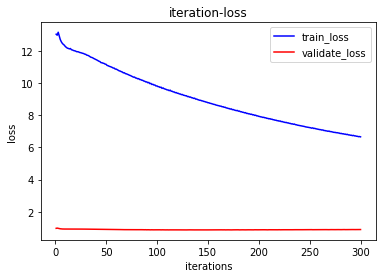

train done...


In [1]:
import math
import numpy as np
from numpy.random import RandomState
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix
from matplotlib import pyplot as plt
import time
import copy
from numpy import random
from scipy.sparse import coo_matrix
from scipy.sparse import csr_matrix
from tqdm import tqdm

def fx(x):
    return (x - 1) / 4

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# The derivative of sigmoid
def sigmoid_(x):
    val = sigmoid(x)
    return val*(1-val)

class MF:
    def __init__(self, R, Validate, C, lr = 0.01,momentum=0.8,
                 lambda_c=10, lambda_u=0.001, lambda_v=0.001, lambda_z=0.001, latent_size=10,iters=1000,seed=None):
        """
        :param R: train set of ratings_data
        :param Validate: validate set of ratings_data
        :param C: trust matrix of users
        :param lr: learning rate
        :param momentum:
        :param lambda_c:
        :param lambda_u:
        :param lambda_v:
        :param lambda_z:
        :param latent_size:
        :param iters: iteration
        :param seed:
        """
        self.R = R
        self.Validate= Validate
        self.C = C
        self.lambda_c = lambda_c
        self.lambda_u = lambda_u
        self.lambda_z = lambda_z
        self.lambda_v = lambda_v
        self.latent_size = latent_size
        self.random_state = RandomState(seed)
        self.iters = iters
        self.lr = lr
        self.U = np.mat(self.random_state.rand(latent_size, np.size(R, 0)))
        self.V = np.mat(self.random_state.rand(latent_size, np.size(R, 1)))
        self.Z = np.mat(self.random_state.rand(latent_size, np.size(C, 1)))
        self.momentum = momentum


    # the MAE for train set
    def train_loss(self, UVdata):
        loss = (np.fabs(4 * sigmoid(UVdata) + 1 - self.R.data)).sum()
        loss /= self.R.shape[0]
        return loss

    # the MAE for validate_set
    def vali_loss(self):
        dif = 0.0
        index = self.Validate.nonzero()
        data = self.Validate.data
        tot = data.shape[0]
        for k in range(tot):
            predict = 4*sigmoid((self.U[:,index[0][k]].T*self.V[:,index[1][k]])[0,0])+1
            dif += math.fabs(data[k] - predict)
        return dif / tot


    def train(self):
        Rindex = self.R.nonzero()
        Cindex = self.C.nonzero()
        Rdata = fx(self.R.data)
        Cdata = self.C.data
        Rnum = Rdata.shape[0]
        Cnum = Cdata.shape[0]
        UVdata = copy.deepcopy(Rdata)
        UZdata = copy.deepcopy(Cdata)
        momentum_u = np.mat(np.zeros(self.U.shape))
        momentum_v = np.mat(np.zeros(self.V.shape))
        momentum_z = np.mat(np.zeros(self.Z.shape))
        train_loss_list = []
        validate_loss_list = []
        begin = time.time()
        minloss = 5.0
        for it in range(self.iters):
            start = time.time()
            for k in range(Rnum):
                UVdata[k] = (self.U[:, Rindex[0][k]].T * self.V[:, Rindex[1][k]])[0][0]
            for k in range(Cnum):
                UZdata[k] = (self.U[:, Cindex[0][k]].T * self.Z[:, Cindex[1][k]])[0][0]

            UV = csr_matrix(((sigmoid(UVdata) - Rdata) * sigmoid_(UVdata), Rindex), self.R.shape)
            UZ = csr_matrix(((sigmoid(UZdata) - Cdata) * sigmoid_(UZdata), Cindex), self.C.shape)

            U = csr_matrix(self.U)
            V = csr_matrix(self.V)
            Z = csr_matrix(self.Z)

            grads_u = self.lambda_u*U + UV.dot(V.T).T + self.lambda_c * UZ.dot(Z.T).T
            grads_v = UV.T.dot(U.T).T + self.lambda_v*V
            grads_z = self.lambda_c * UZ.T.dot(U.T).T + self.lambda_z*Z
            momentum_u = self.momentum * momentum_u + grads_u
            momentum_v = self.momentum * momentum_v + grads_v
            momentum_z = self.momentum * momentum_z + grads_z

            self.U = self.U - self.lr*momentum_u
            self.V = self.V - self.lr*momentum_v
            self.Z = self.Z - self.lr*momentum_z
            trloss = self.train_loss(UVdata)
            valiloss = self.vali_loss()
            train_loss_list.append(trloss)
            validate_loss_list.append(valiloss)
            traintxt = open("train_loss_list___.txt",'a+')
            valitxt = open("validate_loss_list___.txt",'a+')
            traintxt.write(str(trloss)+"\n")
            valitxt.write(str(valiloss)+"\n")
            #np.savetxt("train_loss_list.txt", train_loss_list)
            #np.savetxt("validate_loss_list.txt", validate_loss_list)
            end = time.time()
            print("iter:{}, last_train_loss:{}, validate_loss:{}, timecost:{}, have run:{}".format(it + 1, trloss,
                                                                                                   valiloss,
                                                                                                   end - start,
                                                                                                   end - begin))
            np.savetxt("U_last.txt", self.U)
            np.savetxt("V_last.txt", self.V)
            np.savetxt("Z_last.txt", self.Z)
            if trloss<minloss:
                minloss = trloss
                np.savetxt("U_min" + ".txt", self.U)
                np.savetxt("V_min" + ".txt", self.V)
                np.savetxt("Z_min" + ".txt", self.Z)

        x = np.linspace(1, self.iters, self.iters)
        plt.plot(x, train_loss_list, 'b', label='train_loss')
        plt.plot(x, validate_loss_list, 'r', label='validate_loss')
        plt.legend()
        plt.title("iteration-loss")
        plt.xlabel('iterations')
        plt.ylabel('loss')
        plt.savefig('iteration-loss.png')
        plt.show()
        return self.U, self.V, self.Z, train_loss_list, validate_loss_list


def sigmoid(x):
    return 1.0/(1.0+np.exp(-x))

def get_trust_data(filename="/content/drive/MyDrive/Colab Notebooks/epinions_dataset/trust_data.txt",theshape=(49290,49290)):
    f = open(filename)
    lines = f.readlines()
    row = []
    col = []
    data = []
    for line in tqdm(lines):
        alist = line.strip('\n').split()
        row.append(int(alist[0])-1)
        col.append(int(alist[1])-1)
        data.append(float(alist[2]))
    mtx = coo_matrix((data, (row, col)), shape=theshape)
    indeg = mtx.sum(axis=0)
    outdeg = mtx.sum(axis=1)
    factor = copy.deepcopy(mtx)
    for k in range(factor.data.shape[0]):
        i = factor.row[k]
        j = factor.col[k]
        factor.data[k] = math.sqrt(indeg[0, j]/(indeg[0,j]+outdeg[i, 0]))
    return csr_matrix(factor)

def get_ratings_data(filename="/content/drive/MyDrive/Colab Notebooks/epinions_dataset/ratings_data.txt",theshape=(49290,139739)):
    f = open(filename)
    train_data = []
    train_row = []
    train_col = []
    vali_data = []
    vali_row = []
    vali_col = []
    lines = f.readlines()

    random.shuffle(lines)
    ind = -1
    pos = int(len(lines)*0.99)
    for line in tqdm(lines):
        ind += 1
        alist = line.strip('\n').split()
        if ind>=pos:
            vali_row.append(int(alist[0]))
            vali_col.append(int(alist[1]))
            vali_data.append(int(alist[2]))
            continue
        train_row.append(int(alist[0]))
        train_col.append(int(alist[1]))
        train_data.append(int(alist[2]))

    train_mtx = csr_matrix((train_data, (train_row,train_col)), shape=theshape, dtype='float64')
    vali_mtx = csr_matrix((vali_data, (vali_row, vali_col)), shape=theshape, dtype='float64')
    return train_mtx, vali_mtx

if __name__ == '__main__':
    print("loading data...")
    trust_data = get_trust_data()
    # train set and validae set
    ratings_data_train, ratings_data_validate = get_ratings_data()
    print("loading done...")
    print("begin to train...")
    socmodel = MF(ratings_data_train, ratings_data_validate, trust_data, lr=0.01, momentum=0.5, latent_size=10,iters=300)
    U,V,Z,train_loss_list, validate_loss_list = socmodel.train()
    print("train done...")


In [1]:
pwd

'/content'

In [2]:
cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks
